In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

## Auto-correlationand partial auto-correlation examples

We'll plot the auto-correlation funcion (ACF) of our UK unemployment time series data. We'll use the plot_acf function from the statsmodels package to do this 

First we'll read in the raw data and take a look at it

In [2]:
df_unemployment = pd.read_csv("../Data/uk_unemployment_rate_monthly.csv")

In [3]:
df_unemployment.head()

,t,Period,Unemployment
0,1,1971 FEB,3.8
1,2,1971 MAR,3.9
2,3,1971 APR,4.0
3,4,1971 MAY,4.1
4,5,1971 JUN,4.1


Next we can use the ACF functionality from the statsmodels package to plot the auto-correlation at various different lags. At lag zero ($k=0$) the auto-correlation is 1, as the numerator and denominator are both just the sample variance. The shaded blue area represents the 95% confidence interval (centered on zero), so if the auto-correlation value is outside the 95% confidence value we can conclude that the auto-correlation is statistically significant. This ACF plot would suggest that there are statistically significant auto-correlation values at multiple different lags. However, as we discuss in the main text, if we have auto-correlation at lag $k$, then we will have auto-correlation at a lag $k' > k$. To reveal the real underlying auto-correlation structure we are better using the partial auto-correlation function. We'll do that next

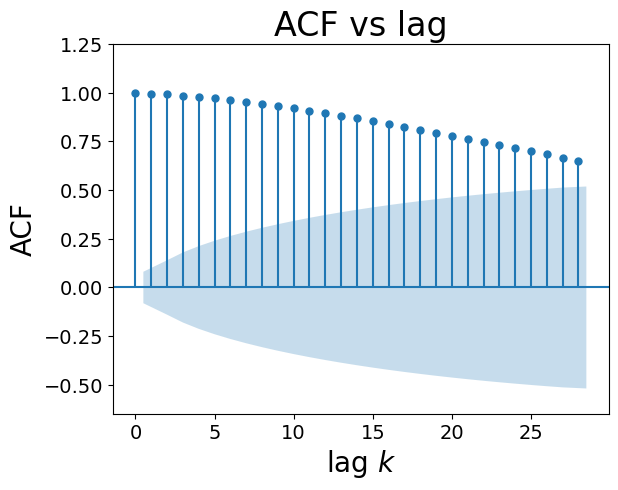

In [4]:
plot_acf(df_unemployment['Unemployment'], auto_ylims=True)
plt.title('ACF vs lag', fontsize=24)
plt.xlabel(r'lag $k$', fontsize=20)
plt.ylabel('ACF', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

This ACF plot would suggest that there are statistically significant auto-correlation values at multiple different lags. However, as we discuss in the main text, if we have auto-correlation at lag $k$, then we will have auto-correlation at a lag $k' > k$. To reveal the real underlying auto-correlation structure we are better using the partial auto-correlation function. We'll do that next using the PACF functionality from the statsmodels package.

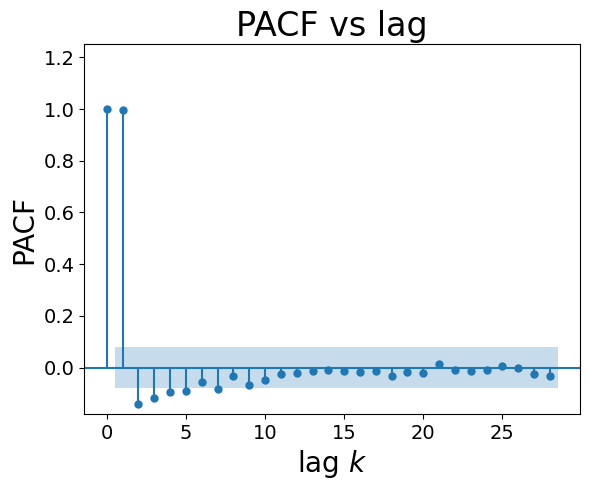

In [5]:
plot_pacf(df_unemployment['Unemployment'], method='ywm', auto_ylims=True)
plt.title('PACF vs lag', fontsize=24)
plt.xlabel(r'lag $k$', fontsize=20)
plt.ylabel('PACF', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Again, the blue shaded region shows the width of the 95% confidence interval, so any partial auto-correlation function values outside the blue region indicates a statistically significant PACF value. The first value is at lag $k=0$ and so automatically has a PACF value of 1. We can see that there is a strong partial auto-correlation at lag $k=1$, with some weaker negative partial auto-correlation at lags $k=2$ and $k=3$.

## Auto.arima example

We'll use the solar activity dataset that is part of the statsmodels package. For simplicity we have created a de-seasonalized and centred version of this data. The data is in the sunactivity_deseasonalized.csv file in the Data folder of the github repository. 

The first thing we need to do is read in the data.

In [6]:
# Read in the de-seasonalized and centered sun activity data
df_sunactivity = pd.read_csv('../Data/sunactivity_deseasonalized.csv')

In [7]:
# We'll split the data into a training segment and a hold-out period
# at the end, which we'll forecast using our ARIMA model
y = df_sunactivity['sunactivity_deseasonalized']

# Set the number of forecast steps
n_steps = 6

# Calculate the length of the training data and extract
n_train = y.shape[0] - n_steps
y_train = y[0:n_train]

Let's take a look at the ACF

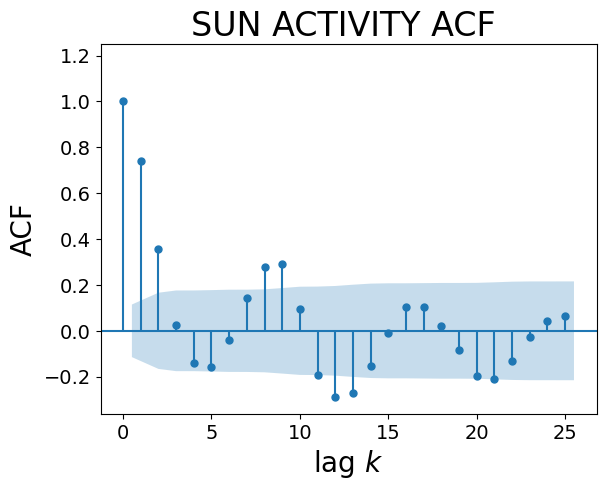

In [8]:
plot_acf(y_train, auto_ylims=True)
plt.title('SUN ACTIVITY ACF ', fontsize=24)
plt.xlabel(r'lag $k$', fontsize=20)
plt.ylabel('ACF', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

The ACF plot hints at 3 auto-regressive parameters. Let's check the PACF plot.

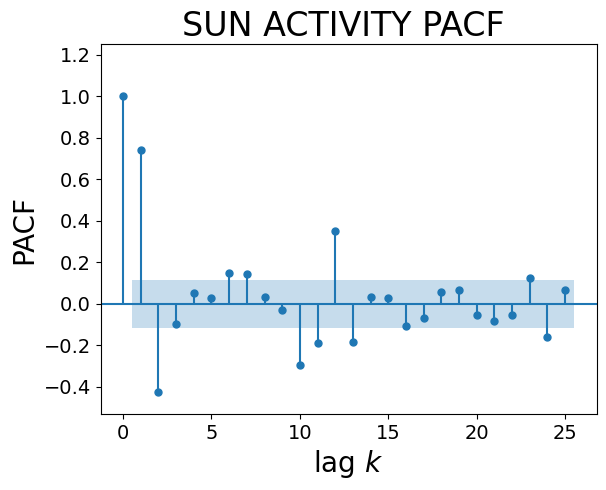

In [9]:
plot_pacf(y_train, method='ldb', auto_ylims=True)
plt.title('SUN ACTIVITY PACF ', fontsize=24)
plt.xlabel(r'lag $k$', fontsize=20)
plt.ylabel('PACF', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

The PACF plot still suggests an AR(3) model. There are some contributions at lags 10 and 12, but we'll keep the model simple and try an AR(3) model. Let's see what auto.arima suggests. We'll use the auto_arima function from the pmdarima package.

In [10]:
# Run the auto_arima function
auto_arima(y_train)

ARIMA(order=(3, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

auto.arima also suggests an AR(3) model. So let's fit an AR(3) model using the statsmodels package

In [11]:
y_arima = ARIMA(y_train, order=(3,0,0))
y_fitted = y_arima.fit()

Let's look at the fitted model

In [12]:
print(y_fitted.summary())

                                   SARIMAX Results                                    
Dep. Variable:     sunactivity_deseasonalized   No. Observations:                  292
Model:                         ARIMA(3, 0, 0)   Log Likelihood               -1288.099
Date:                        Tue, 09 Jul 2024   AIC                           2586.198
Time:                                16:28:38   BIC                           2604.582
Sample:                                     0   HQIC                          2593.562
                                        - 292                                         
Covariance Type:                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2545      2.990      0.085      0.932      -5.606       6.115
ar.L1          1.0201      0.047     21.718      0.000       0.928 

We can compare the model predictions for the training set with the actual training data

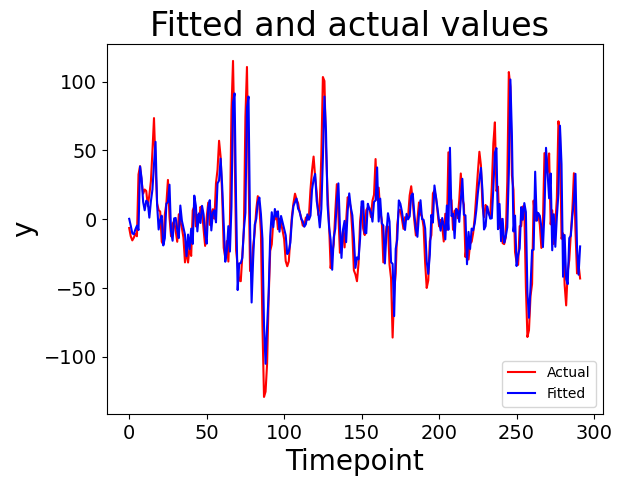

In [13]:
plt.plot(y_train, 'red', label='Actual')
plt.plot(y_fitted.predict(),'blue', label='Fitted')
plt.title('Fitted and actual values ', fontsize=24)
plt.xlabel('Timepoint', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right')
plt.show()

We'll check the residuals of the of the model to see if there is any clear and obvious remaining structure

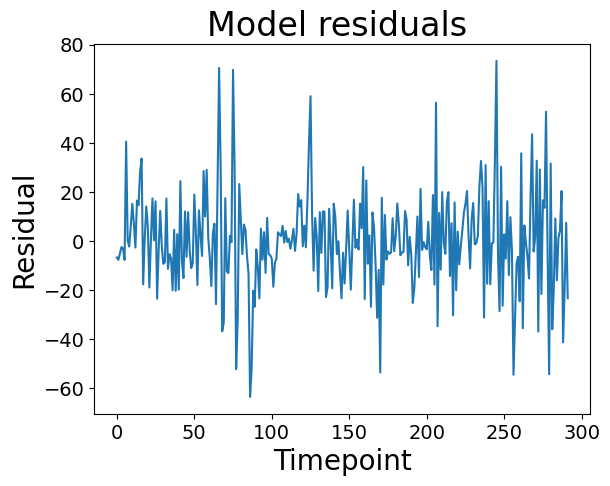

In [14]:
plt.plot(y_fitted.resid)
plt.title('Model residuals ', fontsize=24)
plt.xlabel('Timepoint', fontsize=20)
plt.ylabel('Residual', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

We'll check the distribution of residuals to see if they deviate markedly from a Normal(0,1) distribution.

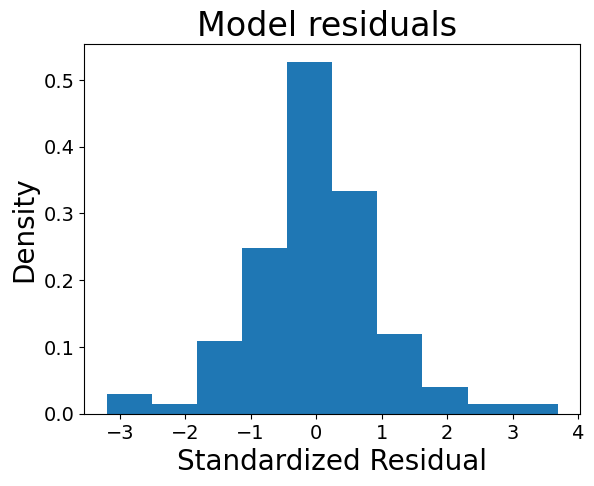

In [15]:
plt.hist(y_fitted.resid/np.std(y_fitted.resid), density=True)
plt.title('Model residuals ', fontsize=24)
plt.xlabel('Standardized Residual', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

We could formally test the distribution of the residuals against a Normal(0,1), but just looking at the histogram suggests it is more peaked around zero than a Normal(0,1) distribution and so suggests that the residuals don't come from a Normal(0,1) distribution. This would suggest we could improve the model. For example, the model summary indicates the lag 3 auto-regressive coefficient is not statistically significant, so we can potentially simplify the model by using an AR(2) model. 

However, the model may still be sufficiently accurate for our needs. Let's see how it performs over a short-range forecast.

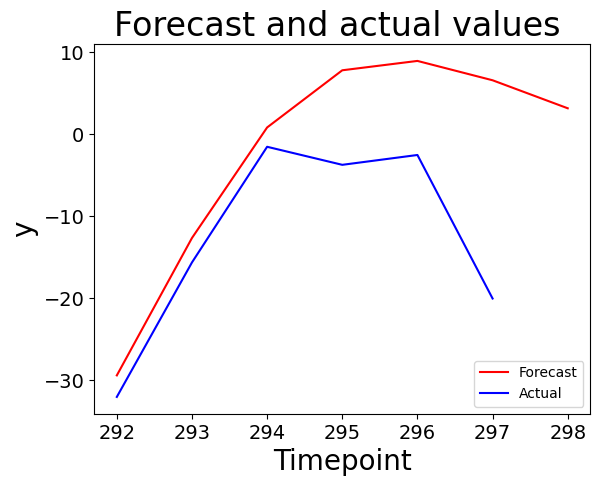

In [16]:
plt.plot(y_fitted.predict(start=n_train, end=n_train+n_steps, dynamic=True), 'red', label='Forecast')
plt.plot(y[n_train:(n_train+n_steps)], 'blue', label='Actual')
plt.title('Forecast and actual values ', fontsize=24)
plt.xlabel('Timepoint', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right')
plt.show()